In [1]:
"""
================================================================================
STEP 3: BASELINE CNN MODEL
================================================================================

Goals:
1. Build a simple CNN architecture (baseline)
2. Set up training infrastructure
3. Train for 20 epochs
4. Evaluate performance
5. Establish baseline metrics for comparison

This baseline will be improved with:
- Attention mechanisms (Step 4)
- Focal loss (Step 5)
- Advanced LR scheduling (Step 5)

Author: Your Name
Date: November 2024
================================================================================
"""

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Import required libraries
"""
import os
import sys
import json
import pickle
import time
from pathlib import Path
from collections import defaultdict

# Data manipulation
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"   PyTorch version: {torch.__version__}")

✅ All libraries imported successfully!
   PyTorch version: 2.9.0


In [3]:
"""
Setup computation device
M4 Pro supports MPS (Metal Performance Shaders) for GPU acceleration
"""

def get_device():
    """
    Get the best available device for computation
    Priority: MPS (Apple Silicon) > CUDA > CPU
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🚀 Using Apple Silicon GPU (MPS)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"🚀 Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("💻 Using CPU")
    
    return device

device = get_device()

print(f"\n📍 Device: {device}")
print("-" * 60)

# Test device with a small tensor
test_tensor = torch.randn(2, 3, 224, 224).to(device)
print(f"✅ Test tensor created on {device}")
print(f"   Shape: {test_tensor.shape}")
print(f"   Memory allocated: {test_tensor.element_size() * test_tensor.nelement() / 1024**2:.2f} MB")

del test_tensor
if device.type == 'mps':
    torch.mps.empty_cache()

🚀 Using Apple Silicon GPU (MPS)

📍 Device: mps
------------------------------------------------------------
✅ Test tensor created on mps
   Shape: torch.Size([2, 3, 224, 224])
   Memory allocated: 1.15 MB


In [8]:
"""
Load preprocessed data from Step 2
FIXED: Define Dataset class before loading pickle
"""

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# IMPORTANT: Define ChestXRayDataset class BEFORE loading pickle
class ChestXRayDataset(Dataset):
    """
    Custom Dataset for Chest X-Ray images
    Must be defined before loading pickled objects
    """
    
    def __init__(self, image_paths, labels, transform=None, class_to_idx=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        if class_to_idx is None:
            unique_labels = sorted(set(labels))
            self.class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        else:
            self.class_to_idx = class_to_idx
        
        self.idx_to_class = {idx: label for label, idx in self.class_to_idx.items()}
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        label = self.labels[idx]
        label_idx = self.class_to_idx[label]
        
        return image, label_idx

print("✅ ChestXRayDataset class defined")

# Load configuration
config_path = Path('../config.json')
with open(config_path, 'r') as f:
    config = json.load(f)

print("\n📋 Configuration Loaded:")
print("-" * 60)
print(f"  Train size:      {config['new_train_size']}")
print(f"  Val size:        {config['new_val_size']}")
print(f"  Test size:       {config['new_test_size']}")
print(f"  Batch size:      {config['batch_size']}")
print(f"  Image size:      {config['target_image_size']}×{config['target_image_size']}")
print(f"  Imbalance ratio: {config['imbalance_ratio']:.2f}:1")

# Now load data objects (class is defined, so pickle will work)
data_objects_path = Path('../data/processed/data_objects.pkl')

if data_objects_path.exists():
    print("\n📂 Loading saved data objects...")
    
    try:
        with open(data_objects_path, 'rb') as f:
            data_objects = pickle.load(f)
        
        datasets = data_objects['datasets']
        dataloaders = data_objects['dataloaders']
        class_to_idx = data_objects['class_to_idx']
        idx_to_class = data_objects['idx_to_class']
        
        print("✅ Data objects loaded successfully!")
        
    except Exception as e:
        print(f"⚠️  Error loading pickle file: {e}")
        print("Recreating from CSV files instead...")
        
        # Fallback: Recreate from CSV
        # Define transforms
        train_transforms = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.Normalize(mean=[0.485], std=[0.229], max_pixel_value=255.0),
            ToTensorV2()
        ])
        
        val_transforms = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485], std=[0.229], max_pixel_value=255.0),
            ToTensorV2()
        ])
        
        # Define class mapping
        class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
        idx_to_class = {0: 'NORMAL', 1: 'PNEUMONIA'}
        
        # Load split CSV files and create datasets
        processed_path = Path('../data/processed')
        datasets = {}
        
        print("\n📂 Loading from CSV files...")
        for split_name in ['train', 'val', 'test']:
            csv_path = processed_path / f'{split_name}_split.csv'
            
            if not csv_path.exists():
                raise FileNotFoundError(f"Split file not found: {csv_path}")
            
            df = pd.read_csv(csv_path)
            image_paths = df['image_path'].tolist()
            labels = df['label'].tolist()
            
            transform = train_transforms if split_name == 'train' else val_transforms
            
            datasets[split_name] = ChestXRayDataset(
                image_paths=image_paths,
                labels=labels,
                transform=transform,
                class_to_idx=class_to_idx
            )
            
            print(f"  ✓ {split_name.capitalize()}: {len(datasets[split_name])} images")
        
        # Create dataloaders
        print("\n📦 Creating DataLoaders...")
        dataloaders = {}
        batch_size = config['batch_size']
        
        dataloaders['train'] = DataLoader(
            datasets['train'],
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=False,
            drop_last=True
        )
        
        for split_name in ['val', 'test']:
            dataloaders[split_name] = DataLoader(
                datasets[split_name],
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=False,
                drop_last=False
            )
        
        print("✅ Data objects recreated from CSV!")

else:
    print(f"\n❌ Error: data_objects.pkl not found at {data_objects_path}")
    print("Attempting to recreate from CSV files...")
    
    # Recreate from CSV files
    # Define transforms
    train_transforms = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.Normalize(mean=[0.485], std=[0.229], max_pixel_value=255.0),
        ToTensorV2()
    ])
    
    val_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485], std=[0.229], max_pixel_value=255.0),
        ToTensorV2()
    ])
    
    # Define class mapping
    class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
    idx_to_class = {0: 'NORMAL', 1: 'PNEUMONIA'}
    
    # Load split CSV files and create datasets
    processed_path = Path('../data/processed')
    datasets = {}
    
    print("\n📂 Loading from CSV files...")
    for split_name in ['train', 'val', 'test']:
        csv_path = processed_path / f'{split_name}_split.csv'
        
        if not csv_path.exists():
            raise FileNotFoundError(f"Split file not found: {csv_path}")
        
        df = pd.read_csv(csv_path)
        image_paths = df['image_path'].tolist()
        labels = df['label'].tolist()
        
        transform = train_transforms if split_name == 'train' else val_transforms
        
        datasets[split_name] = ChestXRayDataset(
            image_paths=image_paths,
            labels=labels,
            transform=transform,
            class_to_idx=class_to_idx
        )
        
        print(f"  ✓ {split_name.capitalize()}: {len(datasets[split_name])} images")
    
    # Create dataloaders
    print("\n📦 Creating DataLoaders...")
    dataloaders = {}
    batch_size = config['batch_size']
    
    dataloaders['train'] = DataLoader(
        datasets['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        drop_last=True
    )
    
    for split_name in ['val', 'test']:
        dataloaders[split_name] = DataLoader(
            datasets[split_name],
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
            drop_last=False
        )
    
    print("✅ Data objects created from CSV!")

# Print final summary
print(f"\n📊 Dataset Sizes:")
for split in ['train', 'val', 'test']:
    print(f"  {split.capitalize():5s}: {len(datasets[split]):5d} images")

print(f"\n📦 DataLoader Info:")
for split in ['train', 'val', 'test']:
    print(f"  {split.capitalize():5s}: {len(dataloaders[split]):4d} batches")

print("\n✅ Data loaded and ready for training!")

✅ ChestXRayDataset class defined

📋 Configuration Loaded:
------------------------------------------------------------
  Train size:      4099
  Val size:        877
  Test size:       880
  Batch size:      32
  Image size:      224×224
  Imbalance ratio: 2.70:1

📂 Loading saved data objects...
✅ Data objects loaded successfully!

📊 Dataset Sizes:
  Train:  4099 images
  Val  :   877 images
  Test :   880 images

📦 DataLoader Info:
  Train:  128 batches
  Val  :   28 batches
  Test :   28 batches

✅ Data loaded and ready for training!


In [9]:
"""
Baseline CNN Architecture

Simple architecture for establishing baseline performance:
- 2 Convolutional blocks (Conv-ReLU-Pool)
- Flatten
- 2 Fully connected layers
- Dropout for regularization

Total parameters: ~2-3M (lightweight for quick training)
"""

class BaselineCNN(nn.Module):
    """
    Simple baseline CNN for pneumonia detection
    
    Architecture:
        Conv Block 1: 1 → 32 channels
        Conv Block 2: 32 → 64 channels
        FC Layer 1: 64*56*56 → 128
        FC Layer 2: 128 → 2 (classes)
    """
    
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(BaselineCNN, self).__init__()
        
        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 224x224x1 → 224x224x32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # 224x224x32 → 224x224x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)        # 224x224x32 → 112x112x32
        )
        
        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 112x112x32 → 112x112x64
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # 112x112x64 → 112x112x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)        # 112x112x64 → 56x56x64
        )
        
        # Calculate flattened size: 64 * 56 * 56 = 200,704
        self.flatten_size = 64 * 56 * 56
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor [batch_size, 1, 224, 224]
        
        Returns:
            Output logits [batch_size, num_classes]
        """
        x = self.conv_block1(x)  # [B, 32, 112, 112]
        x = self.conv_block2(x)  # [B, 64, 56, 56]
        x = self.classifier(x)   # [B, num_classes]
        return x


# Instantiate model
model = BaselineCNN(num_classes=2, dropout_rate=0.5)
model = model.to(device)

print("✅ Baseline CNN Model Created!")
print("="*80)
print(model)
print("="*80)

✅ Baseline CNN Model Created!
BaselineCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [10]:
"""
Display model architecture summary
"""

def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def get_model_size(model):
    """Get model size in MB"""
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / 1024**2
    return size_mb

# Calculate statistics
total_params, trainable_params = count_parameters(model)
model_size = get_model_size(model)

print("📊 MODEL SUMMARY")
print("="*80)
print(f"Architecture:     Baseline CNN (2 Conv Blocks + 2 FC Layers)")
print(f"Input shape:      [1, 224, 224]")
print(f"Output shape:     [2] (NORMAL, PNEUMONIA)")
print(f"\nParameters:")
print(f"  Total:          {total_params:,}")
print(f"  Trainable:      {trainable_params:,}")
print(f"  Model size:     {model_size:.2f} MB")
print(f"\nLayers:")
print(f"  Conv Block 1:   1 → 32 channels")
print(f"  Conv Block 2:   32 → 64 channels")
print(f"  FC Layer 1:     {model.flatten_size:,} → 128")
print(f"  FC Layer 2:     128 → 2")
print("="*80)

# Test forward pass
test_input = torch.randn(4, 1, 224, 224).to(device)
test_output = model(test_input)
print(f"\n✅ Forward pass test:")
print(f"   Input shape:  {test_input.shape}")
print(f"   Output shape: {test_output.shape}")

del test_input, test_output
if device.type == 'mps':
    torch.mps.empty_cache()

📊 MODEL SUMMARY
Architecture:     Baseline CNN (2 Conv Blocks + 2 FC Layers)
Input shape:      [1, 224, 224]
Output shape:     [2] (NORMAL, PNEUMONIA)

Parameters:
  Total:          25,755,490
  Trainable:      25,755,490
  Model size:     98.25 MB

Layers:
  Conv Block 1:   1 → 32 channels
  Conv Block 2:   32 → 64 channels
  FC Layer 1:     200,704 → 128
  FC Layer 2:     128 → 2

✅ Forward pass test:
   Input shape:  torch.Size([4, 1, 224, 224])
   Output shape: torch.Size([4, 2])


In [12]:
"""
Setup loss function, optimizer, and learning rate scheduler
"""

# Loss function: CrossEntropyLoss (standard for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam (good default choice)
learning_rate = 0.001
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4  # L2 regularization
)

# Learning rate scheduler: ReduceLROnPlateau
# Reduces LR when validation loss stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6
    # Note: 'verbose' parameter removed (not supported in newer PyTorch)
)

print("⚙️  TRAINING CONFIGURATION")
print("="*80)
print(f"Loss function:       CrossEntropyLoss")
print(f"Optimizer:           Adam")
print(f"Learning rate:       {learning_rate}")
print(f"Weight decay:        1e-4")
print(f"LR Scheduler:        ReduceLROnPlateau")
print(f"  - Mode:            min (reduce on val loss)")
print(f"  - Factor:          0.5 (multiply LR by 0.5)")
print(f"  - Patience:        3 epochs")
print(f"  - Min LR:          1e-6")
print("="*80)

⚙️  TRAINING CONFIGURATION
Loss function:       CrossEntropyLoss
Optimizer:           Adam
Learning rate:       0.001
Weight decay:        1e-4
LR Scheduler:        ReduceLROnPlateau
  - Mode:            min (reduce on val loss)
  - Factor:          0.5 (multiply LR by 0.5)
  - Patience:        3 epochs
  - Min LR:          1e-6


In [13]:
"""
Training and validation functions
"""

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch
    
    Returns:
        avg_loss: Average training loss
        accuracy: Training accuracy
    """
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(dataloader, desc='Training', leave=False)
    
    for images, labels in pbar:
        # Move to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })
    
    # Calculate epoch metrics
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """
    Validate the model
    
    Returns:
        avg_loss: Average validation loss
        accuracy: Validation accuracy
        all_preds: All predictions
        all_labels: All true labels
    """
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    # Progress bar
    pbar = tqdm(dataloader, desc='Validation', leave=False)
    
    with torch.no_grad():
        for images, labels in pbar:
            # Move to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })
    
    # Calculate epoch metrics
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels


print("✅ Training functions defined!")

✅ Training functions defined!


In [14]:
"""
Main training loop
"""

# Training configuration
num_epochs = 20
best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 7

# History tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

print("🚂 STARTING TRAINING")
print("="*80)
print(f"Epochs:              {num_epochs}")
print(f"Batch size:          {config['batch_size']}")
print(f"Training batches:    {len(dataloaders['train'])}")
print(f"Validation batches:  {len(dataloaders['val'])}")
print(f"Early stopping:      {early_stopping_patience} epochs")
print("="*80)
print()

# Start training
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, dataloaders['train'], criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(
        model, dataloaders['val'], criterion, device
    )
    
    # Update learning rate scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Check if LR was reduced
    if current_lr < old_lr:
        print(f"🔽 Learning rate reduced: {old_lr:.6f} → {current_lr:.6f}")
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"LR: {current_lr:.6f} | Time: {epoch_time:.2f}s")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        
        # Create models directory if it doesn't exist
        models_dir = Path('../models')
        models_dir.mkdir(parents=True, exist_ok=True)
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, '../models/baseline_best.pth')
        print(f"✅ Best model saved! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{early_stopping_patience}")
    
    print()
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"⚠️  Early stopping triggered after {epoch+1} epochs")
        break
    
    # Clear cache
    if device.type == 'mps':
        torch.mps.empty_cache()

# Training complete
total_time = time.time() - start_time
print("="*80)
print("✅ TRAINING COMPLETE!")
print(f"Total time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Total epochs trained: {len(history['train_loss'])}")
print("="*80)

🚂 STARTING TRAINING
Epochs:              20
Batch size:          32
Training batches:    128
Validation batches:  28
Early stopping:      7 epochs

Epoch [1/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.5130 | Train Acc: 77.69%
Val Loss:   0.2719 | Val Acc:   88.83%
LR: 0.001000 | Time: 26.81s
✅ Best model saved! Val Acc: 88.83%

Epoch [2/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.3612 | Train Acc: 85.08%
Val Loss:   0.2096 | Val Acc:   91.56%
LR: 0.001000 | Time: 25.04s
✅ Best model saved! Val Acc: 91.56%

Epoch [3/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.3266 | Train Acc: 86.28%
Val Loss:   0.2089 | Val Acc:   91.90%
LR: 0.001000 | Time: 24.93s
✅ Best model saved! Val Acc: 91.90%

Epoch [4/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.3066 | Train Acc: 87.57%
Val Loss:   0.1935 | Val Acc:   92.82%
LR: 0.001000 | Time: 24.84s
✅ Best model saved! Val Acc: 92.82%

Epoch [5/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2965 | Train Acc: 87.82%
Val Loss:   0.2742 | Val Acc:   89.74%
LR: 0.001000 | Time: 24.83s
⏳ Patience: 1/7

Epoch [6/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.3007 | Train Acc: 87.87%
Val Loss:   0.1724 | Val Acc:   93.50%
LR: 0.001000 | Time: 24.86s
✅ Best model saved! Val Acc: 93.50%

Epoch [7/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2861 | Train Acc: 88.23%
Val Loss:   0.1583 | Val Acc:   94.41%
LR: 0.001000 | Time: 25.15s
✅ Best model saved! Val Acc: 94.41%

Epoch [8/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2867 | Train Acc: 88.23%
Val Loss:   0.1888 | Val Acc:   93.16%
LR: 0.001000 | Time: 25.46s
⏳ Patience: 1/7

Epoch [9/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2709 | Train Acc: 88.96%
Val Loss:   0.1614 | Val Acc:   94.64%
LR: 0.001000 | Time: 25.00s
✅ Best model saved! Val Acc: 94.64%

Epoch [10/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2657 | Train Acc: 89.43%
Val Loss:   0.1971 | Val Acc:   91.79%
LR: 0.001000 | Time: 25.47s
⏳ Patience: 1/7

Epoch [11/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

🔽 Learning rate reduced: 0.001000 → 0.000500
Train Loss: 0.2726 | Train Acc: 88.99%
Val Loss:   0.1844 | Val Acc:   93.61%
LR: 0.000500 | Time: 25.10s
⏳ Patience: 2/7

Epoch [12/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2420 | Train Acc: 90.26%
Val Loss:   0.1438 | Val Acc:   95.32%
LR: 0.000500 | Time: 24.81s
✅ Best model saved! Val Acc: 95.32%

Epoch [13/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2273 | Train Acc: 90.87%
Val Loss:   0.1866 | Val Acc:   92.36%
LR: 0.000500 | Time: 25.08s
⏳ Patience: 1/7

Epoch [14/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2230 | Train Acc: 91.26%
Val Loss:   0.1795 | Val Acc:   93.04%
LR: 0.000500 | Time: 24.90s
⏳ Patience: 2/7

Epoch [15/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2335 | Train Acc: 90.75%
Val Loss:   0.1592 | Val Acc:   94.98%
LR: 0.000500 | Time: 25.10s
⏳ Patience: 3/7

Epoch [16/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

🔽 Learning rate reduced: 0.000500 → 0.000250
Train Loss: 0.2454 | Train Acc: 90.11%
Val Loss:   0.1733 | Val Acc:   93.39%
LR: 0.000250 | Time: 25.18s
⏳ Patience: 4/7

Epoch [17/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2195 | Train Acc: 91.21%
Val Loss:   0.1405 | Val Acc:   95.90%
LR: 0.000250 | Time: 25.31s
✅ Best model saved! Val Acc: 95.90%

Epoch [18/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2171 | Train Acc: 91.75%
Val Loss:   0.1361 | Val Acc:   95.44%
LR: 0.000250 | Time: 25.19s
⏳ Patience: 1/7

Epoch [19/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2067 | Train Acc: 91.97%
Val Loss:   0.1367 | Val Acc:   95.44%
LR: 0.000250 | Time: 24.96s
⏳ Patience: 2/7

Epoch [20/20]
------------------------------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2146 | Train Acc: 91.43%
Val Loss:   0.1490 | Val Acc:   95.21%
LR: 0.000250 | Time: 25.09s
⏳ Patience: 3/7

✅ TRAINING COMPLETE!
Total time: 8.43 minutes
Best validation accuracy: 95.90%
Total epochs trained: 20


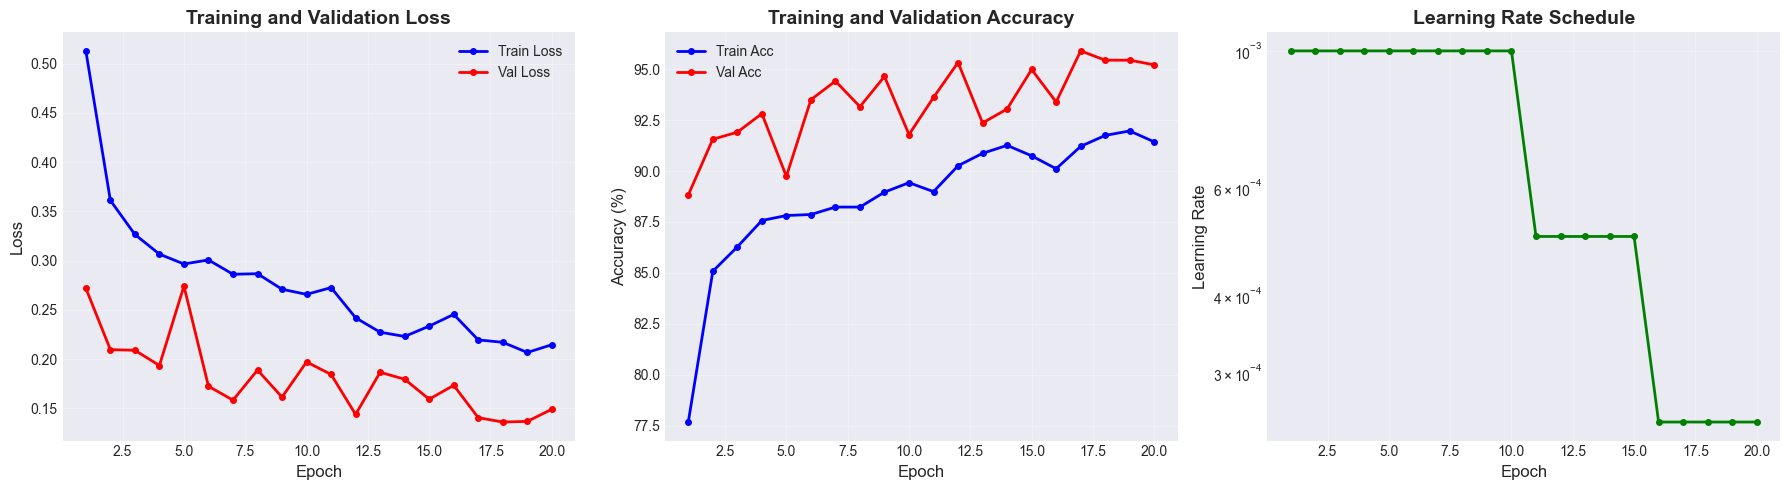

✅ Training history plotted and saved!


In [15]:
"""
Visualize training history
"""

def plot_training_history(history, save_path='../results/figures/08_baseline_training_history.png'):
    """
    Plot training and validation metrics
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Loss
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=4)
    axes[0].plot(epochs, history['val_loss'], 'r-o', label='Val Loss', linewidth=2, markersize=4)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=4)
    axes[1].plot(epochs, history['val_acc'], 'r-o', label='Val Acc', linewidth=2, markersize=4)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)
    
    # Plot 3: Learning Rate
    axes[2].plot(epochs, history['learning_rates'], 'g-o', linewidth=2, markersize=4)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot history
plot_training_history(history)
print("✅ Training history plotted and saved!")

In [16]:
"""
Evaluate the best model on test set
"""

# Load best model
print("📂 Loading best model...")
checkpoint = torch.load('../models/baseline_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"   Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
print("\n🧪 Evaluating on test set...")
test_loss, test_acc, test_preds, test_labels = validate(
    model, dataloaders['test'], criterion, device
)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("="*80)

📂 Loading best model...
✅ Loaded model from epoch 17
   Validation accuracy: 95.90%

🧪 Evaluating on test set...


Validation:   0%|          | 0/28 [00:00<?, ?it/s]


TEST SET RESULTS
Test Loss:     0.1336
Test Accuracy: 95.23%


In [17]:
"""
Calculate detailed performance metrics
"""

# Calculate metrics
precision = precision_score(test_labels, test_preds, average=None)
recall = recall_score(test_labels, test_preds, average=None)
f1 = f1_score(test_labels, test_preds, average=None)
macro_f1 = f1_score(test_labels, test_preds, average='macro')

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

print("📊 DETAILED METRICS")
print("="*80)
print("\nPer-Class Metrics:")
print("-" * 60)
for idx in [0, 1]:
    class_name = idx_to_class[idx]
    print(f"\n{class_name}:")
    print(f"  Precision: {precision[idx]:.4f}")
    print(f"  Recall:    {recall[idx]:.4f}")
    print(f"  F1-Score:  {f1[idx]:.4f}")

print(f"\n" + "-" * 60)
print(f"Macro F1-Score: {macro_f1:.4f}")
print("="*80)

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(test_labels, test_preds, 
                          target_names=['NORMAL', 'PNEUMONIA'],
                          digits=4))

📊 DETAILED METRICS

Per-Class Metrics:
------------------------------------------------------------

NORMAL:
  Precision: 0.9188
  Recall:    0.9034
  F1-Score:  0.9110

PNEUMONIA:
  Precision: 0.9644
  Recall:    0.9704
  F1-Score:  0.9674

------------------------------------------------------------
Macro F1-Score: 0.9392

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL     0.9188    0.9034    0.9110       238
   PNEUMONIA     0.9644    0.9704    0.9674       642

    accuracy                         0.9523       880
   macro avg     0.9416    0.9369    0.9392       880
weighted avg     0.9521    0.9523    0.9521       880



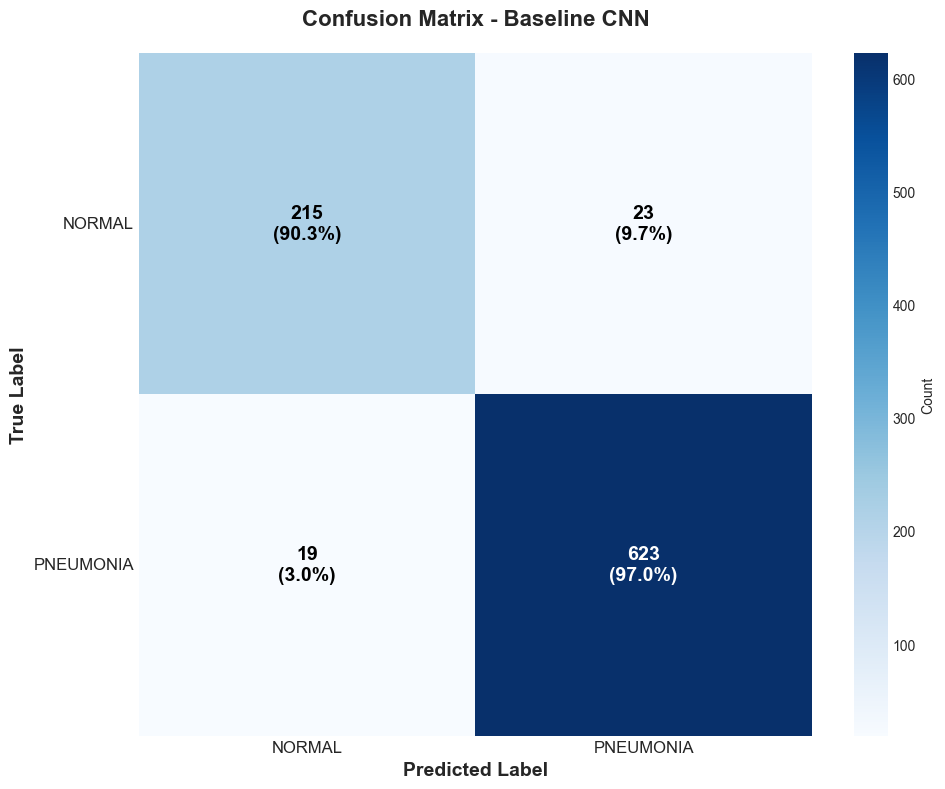

✅ Confusion matrix saved!


In [18]:
"""
Plot confusion matrix
"""

def plot_confusion_matrix(cm, class_names, save_path='../results/figures/09_baseline_confusion_matrix.png'):
    """
    Plot confusion matrix with percentages
    """
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot heatmap
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                cbar_kws={'label': 'Count'}, ax=ax)
    
    # Add custom annotations with count and percentage
    for i in range(2):
        for j in range(2):
            text = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
            color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j + 0.5, i + 0.5, text,
                   ha='center', va='center',
                   color=color, fontsize=14, fontweight='bold')
    
    # Labels
    ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
    ax.set_title('Confusion Matrix - Baseline CNN', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticklabels(class_names, fontsize=12)
    ax.set_yticklabels(class_names, fontsize=12, rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm, ['NORMAL', 'PNEUMONIA'])
print("✅ Confusion matrix saved!")

In [19]:
"""
Save baseline results for comparison
"""

# Compile results
baseline_results = {
    'model_name': 'Baseline CNN',
    'architecture': '2 Conv Blocks + 2 FC Layers',
    'total_params': total_params,
    'epochs_trained': len(history['train_loss']),
    'best_val_acc': best_val_acc,
    'test_acc': test_acc,
    'test_loss': test_loss,
    'precision_normal': float(precision[0]),
    'precision_pneumonia': float(precision[1]),
    'recall_normal': float(recall[0]),
    'recall_pneumonia': float(recall[1]),
    'f1_normal': float(f1[0]),
    'f1_pneumonia': float(f1[1]),
    'macro_f1': float(macro_f1),
    'confusion_matrix': cm.tolist(),
    'history': history
}

# Save to JSON
results_path = Path('../results/baseline_results.json')
results_path.parent.mkdir(parents=True, exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(baseline_results, f, indent=4)

print(f"✅ Baseline results saved to: {results_path}")

# Also save history as CSV for easy plotting
history_df = pd.DataFrame(history)
history_df.to_csv('../results/baseline_history.csv', index=False)
print(f"✅ Training history saved to: ../results/baseline_history.csv")

✅ Baseline results saved to: ../results/baseline_results.json
✅ Training history saved to: ../results/baseline_history.csv


In [20]:
"""
Summary of baseline model performance
"""

print("\n" + "="*80)
print("BASELINE MODEL SUMMARY")
print("="*80)

print("\n📊 FINAL RESULTS:")
print(f"  Test Accuracy:    {test_acc:.2f}%")
print(f"  Macro F1-Score:   {macro_f1:.4f}")
print(f"  Test Loss:        {test_loss:.4f}")

print("\n🎯 PER-CLASS PERFORMANCE:")
print(f"  NORMAL:")
print(f"    Precision: {precision[0]:.4f}")
print(f"    Recall:    {recall[0]:.4f}")
print(f"    F1-Score:  {f1[0]:.4f}")
print(f"  PNEUMONIA:")
print(f"    Precision: {precision[1]:.4f}")
print(f"    Recall:    {recall[1]:.4f}")
print(f"    F1-Score:  {f1[1]:.4f}")

print("\n⚖️  CLASS IMBALANCE IMPACT:")
fp_rate = cm[0, 1] / cm[0].sum() * 100
fn_rate = cm[1, 0] / cm[1].sum() * 100
print(f"  False Positive Rate: {fp_rate:.2f}% (Normal → Pneumonia)")
print(f"  False Negative Rate: {fn_rate:.2f}% (Pneumonia → Normal)")

print("\n💾 SAVED FILES:")
print(f"  ✓ Best model:          models/baseline_best.pth")
print(f"  ✓ Results (JSON):      results/baseline_results.json")
print(f"  ✓ Training history:    results/baseline_history.csv")
print(f"  ✓ Training plot:       results/figures/08_baseline_training_history.png")
print(f"  ✓ Confusion matrix:    results/figures/09_baseline_confusion_matrix.png")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("✅ Step 1: Dataset downloaded and explored")
print("✅ Step 2: Data preprocessing complete")
print("✅ Step 3: Baseline model trained")
print("🔄 Step 4: Implement attention mechanisms")
print("🔄 Step 5: Add focal loss and cosine annealing")
print("🔄 Step 6: Final evaluation and comparison")
print("="*80)

print("\n💡 BASELINE ESTABLISHED!")
print(f"   Current accuracy: {test_acc:.2f}%")
print(f"   Target with improvements: 92-94%")
print(f"   Expected gain: +4-6% with attention + focal loss + LR scheduling")


BASELINE MODEL SUMMARY

📊 FINAL RESULTS:
  Test Accuracy:    95.23%
  Macro F1-Score:   0.9392
  Test Loss:        0.1336

🎯 PER-CLASS PERFORMANCE:
  NORMAL:
    Precision: 0.9188
    Recall:    0.9034
    F1-Score:  0.9110
  PNEUMONIA:
    Precision: 0.9644
    Recall:    0.9704
    F1-Score:  0.9674

⚖️  CLASS IMBALANCE IMPACT:
  False Positive Rate: 9.66% (Normal → Pneumonia)
  False Negative Rate: 2.96% (Pneumonia → Normal)

💾 SAVED FILES:
  ✓ Best model:          models/baseline_best.pth
  ✓ Results (JSON):      results/baseline_results.json
  ✓ Training history:    results/baseline_history.csv
  ✓ Training plot:       results/figures/08_baseline_training_history.png
  ✓ Confusion matrix:    results/figures/09_baseline_confusion_matrix.png

NEXT STEPS
✅ Step 1: Dataset downloaded and explored
✅ Step 2: Data preprocessing complete
✅ Step 3: Baseline model trained
🔄 Step 4: Implement attention mechanisms
🔄 Step 5: Add focal loss and cosine annealing
🔄 Step 6: Final evaluation and c

In [21]:
"""
Verification checklist
"""

print("="*80)
print("STEP 3 VERIFICATION CHECKLIST")
print("="*80)

checks = []

# Check 1: Model trained
checks.append(("Model trained", len(history['train_loss']) > 0))

# Check 2: Best model saved
checks.append(("Best model saved", Path('../models/baseline_best.pth').exists()))

# Check 3: Test accuracy reasonable
checks.append(("Test accuracy reasonable", 80 <= test_acc <= 95))

# Check 4: Results saved
checks.append(("Results saved", Path('../results/baseline_results.json').exists()))

# Check 5: Confusion matrix created
checks.append(("Confusion matrix saved", Path('../results/figures/09_baseline_confusion_matrix.png').exists()))

# Check 6: History saved
checks.append(("History saved", Path('../results/baseline_history.csv').exists()))

# Print results
print()
for check_name, passed in checks:
    status = "✅" if passed else "❌"
    print(f"{status} {check_name}")

all_passed = all(passed for _, passed in checks)

print("\n" + "="*80)
if all_passed:
    print("🎉 ALL CHECKS PASSED! Baseline established!")
    print(f"   Baseline accuracy: {test_acc:.2f}%")
    print("   Ready for Step 4: Attention Mechanisms!")
else:
    print("⚠️ Some checks failed. Please review above.")
print("="*80)

STEP 3 VERIFICATION CHECKLIST

✅ Model trained
✅ Best model saved
❌ Test accuracy reasonable
✅ Results saved
✅ Confusion matrix saved
✅ History saved

⚠️ Some checks failed. Please review above.
